In [2]:
import json
from datasets import load_dataset
import plotly.express as px
#visualize
import matplotlib.pyplot as plt
import os
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import pandas as pd
import nltk
import string
import re
import numpy as np
%matplotlib inline

os.chdir('/Users/jon/Documents/DSDM/term_2/adv_meth_nlp/nlp-final/')

/Users/jon/miniconda3/envs/nlp-final/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data exploration

First load the dataset.

In [3]:
import json
from datasets import load_dataset

# Load the English part of the dataset
train_dataset = load_dataset('nlpaueb/multi_eurlex', 'en', split='train')
test_dataset = load_dataset('nlpaueb/multi_eurlex', 'en', split='test')
val_dataset = load_dataset('nlpaueb/multi_eurlex', 'en', split='validation')

Found cached dataset multi_eurlex (/Users/jon/.cache/huggingface/datasets/nlpaueb___multi_eurlex/en/1.0.0/1addee7110a20c2b01cc3de89456786482e4eea1d2ead0bea3d5383b16cc9fce)
Found cached dataset multi_eurlex (/Users/jon/.cache/huggingface/datasets/nlpaueb___multi_eurlex/en/1.0.0/1addee7110a20c2b01cc3de89456786482e4eea1d2ead0bea3d5383b16cc9fce)
Found cached dataset multi_eurlex (/Users/jon/.cache/huggingface/datasets/nlpaueb___multi_eurlex/en/1.0.0/1addee7110a20c2b01cc3de89456786482e4eea1d2ead0bea3d5383b16cc9fce)


`eurovoc_id` is the ID of a certain area of government activity.

`level` refers to the specificity of a certain topic. For example, european parliament is level 0, quantum computing is level 7.

In [4]:
# Load (label_id, descriptor) mapping 
with open('./data/eurovoc_descriptors.json') as jsonl_file:
    eurovoc_descriptors =  json.load(jsonl_file)

# Get feature map info
train_classlabel = train_dataset.features["labels"].feature
test_classlabel = test_dataset.features["labels"].feature
val_classlabel = val_dataset.features["labels"].feature

# Load (label_id, descriptor) mapping 
with open('./data/eurovoc_concepts.json') as jsonl_file:
    eurovoc_concepts =  json.load(jsonl_file)


Let's take a look at the distribution of labels. 

In [5]:
def get_agg_df(dataset, classlabel):
    df_agg = []
    for i, sample in enumerate(dataset):    
        for label_id in sample['labels']:
            result = {}
            result['celex_id'] = sample['celex_id']
            result['label_id'] = label_id
            result['eurovoc_id'] = classlabel.int2str(label_id)
            result['eurovoc_desc'] = eurovoc_descriptors[classlabel.int2str(label_id)]['en']
            df_agg.append(result)
            # Get the EuroVoc level for the current label ID
            for level, ids in eurovoc_concepts.items():
                if classlabel.int2str(label_id) in ids:
                    result['eurovoc_level'] = level
                    break
    df_agg = pd.DataFrame(df_agg)
    return(df_agg)

train_agg_df = get_agg_df(train_dataset, train_classlabel)
test_agg_df = get_agg_df(test_dataset, test_classlabel)
val_agg_df = get_agg_df(val_dataset, val_classlabel)
df = pd.concat([train_agg_df, test_agg_df, val_agg_df], ignore_index=True)
df['source'] = pd.Series(['train'] * len(train_agg_df) + ['test'] * len(test_agg_df) + ['val'] * len(val_agg_df), dtype='string')

In [6]:
df.head()

,celex_id,label_id,eurovoc_id,eurovoc_desc,eurovoc_level,source
0,32003R1012,2,100148,finance,level_1,train
1,32003R1012,5,100143,international relations,level_1,train
2,32003R1012,10,100142,politics,level_1,train
3,32003R1012,8,100154,transport,level_1,train
4,32003R1012,3,100147,trade,level_1,train


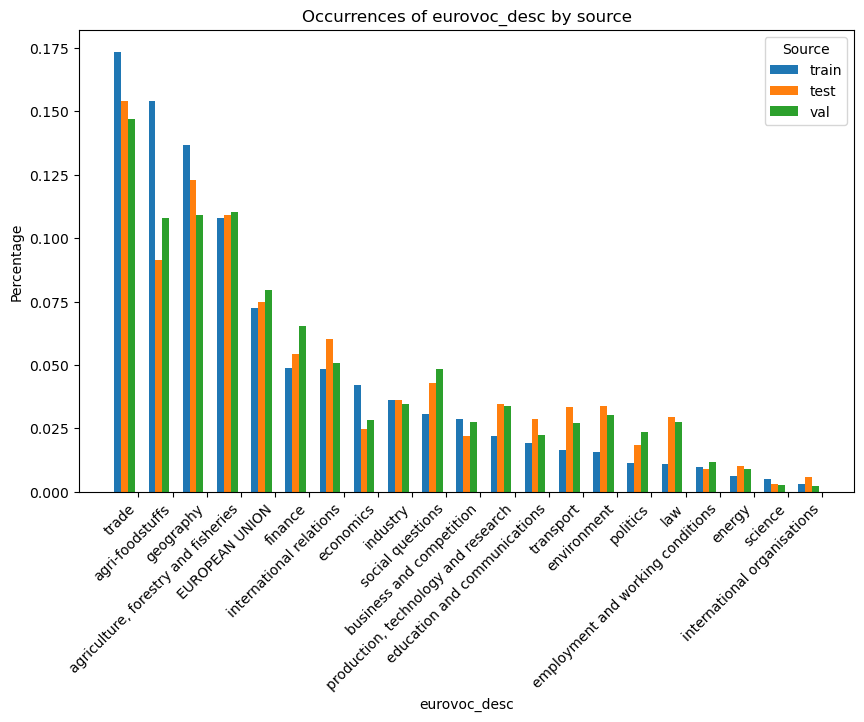

In [7]:

# Group by eurovoc_desc and source, and count occurrences
df_grouped = df.groupby(['eurovoc_desc', 'source']).size().reset_index(name='count')

# Pivot the table to have source as columns and eurovoc_desc as index
df_pivot = df_grouped.pivot_table(index='eurovoc_desc', columns='source', values='count')

# Divide each column by the total count for that source
df_pivot = df_pivot.divide(df_pivot.sum(axis=0), axis=1)

# Sort the pivot table by the train column in descending order
df_pivot = df_pivot.sort_values(by='train', ascending=False)

# Plot a grouped bar chart
fig, ax = plt.subplots(figsize=(10,6))

x = np.arange(len(df_pivot))
width = 0.2

ax.bar(x - width, df_pivot['train'], width, label='train')
ax.bar(x, df_pivot['test'], width, label='test')
ax.bar(x + width, df_pivot['val'], width, label='val')

# Set the plot title and axes labels
ax.set_title('Occurrences of eurovoc_desc by source')
ax.set_xlabel('eurovoc_desc')
ax.set_ylabel('Percentage')

# Add a legend to the plot
ax.legend(title='Source', loc='upper right')

# Set the x-axis tick positions and labels
xticks = x - width / 2 + 0.5
ax.set_xticks(xticks)
ax.set_xticklabels(df_pivot.index, rotation=45, ha='right')

# Show the plot
plt.show()


The only major difference I can see is that agri-foodstuffs is underrepresented in the test set and overrepresented in the training set. 

## Preprocessing

In [8]:
df_train = train_dataset.to_pandas()
df_train.head()

,celex_id,text,labels
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,"[2, 5, 10, 8, 3, 18, 15]"
1,32008R0284,COMMISSION REGULATION (EC) No 284/2008\nof 27 ...,"[3, 18, 17, 6]"
2,32004D0761,COMMISSION DECISION\nof 26 October 2004\nlayin...,"[17, 19, 10, 6, 15]"
3,31992R2310,COMMISSION REGULATION (EEC) No 2310/92 of 31 J...,"[7, 3, 17, 6]"
4,31995R0423,COUNCIL REGULATION (EC) No 423/95 of 20 Februa...,"[17, 19, 6]"


In [9]:


# Download the necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define a function to preprocess a single document
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove numbers and punctuation using regex
    text = re.sub(r'[^\w\s]', '', re.sub(r'\d+', '', text))

    # Tokenize the text into words
    words = nltk.word_tokenize(text)

    # Remove stop words
    stopwords = nltk.corpus.stopwords.words('english')
    filtered_words = [word for word in words if word not in stopwords]

    # Stem the remaining words using Porter Stemmer
    stemmer = nltk.PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in filtered_words]

    # Lemmatize the remaining words using WordNetLemmatizer
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]

    # Join the preprocessed words into a single string
    preprocessed_text = " ".join(lemmatized_words)

    return preprocessed_text

# Preprocess the text in the 'text' column of the DataFrame
df_train['pp_text'] = df_train['text'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /Users/jon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     celex_id                                               text  \
0  32003R1012  Commission Regulation (EC) No 1012/2003\nof 12...   
1  32008R0284  COMMISSION REGULATION (EC) No 284/2008\nof 27 ...   
2  32004D0761  COMMISSION DECISION\nof 26 October 2004\nlayin...   
3  31992R2310  COMMISSION REGULATION (EEC) No 2310/92 of 31 J...   
4  31995R0423  COUNCIL REGULATION (EC) No 423/95 of 20 Februa...   

                     labels                                            pp_text  
0  [2, 5, 10, 8, 3, 18, 15]  commiss regul ec june amend th time council re...  
1            [3, 18, 17, 6]  commiss regul ec march regist certain name reg...  
2       [17, 19, 10, 6, 15]  commiss decis octob lay detail rule applic cou...  
3             [7, 3, 17, 6]  commiss regul eec juli amend regul eec buyingi...  
4               [17, 19, 6]  council regul ec februari amend regul eec lay ...  


In [15]:
df_train.head()

,celex_id,text,labels,pp_text
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,"[2, 5, 10, 8, 3, 18, 15]",june th time impos specif restrict direct pers...
1,32008R0284,COMMISSION REGULATION (EC) No 284/2008\nof 27 ...,"[3, 18, 17, 6]",march regist name regist protect design origin...
2,32004D0761,COMMISSION DECISION\nof 26 October 2004\nlayin...,"[17, 19, 10, 6, 15]",decis octob lay detail direct statist survey c...
3,31992R2310,COMMISSION REGULATION (EEC) No 2310/92 of 31 J...,"[7, 3, 17, 6]",juli buyingin storag oliv oil intervent agenc ...
4,31995R0423,COUNCIL REGULATION (EC) No 423/95 of 20 Februa...,"[17, 19, 6]",februari lay respect hop amount aid produc har...


Now let's look at the most commonly used words and see if there are any words we can add to stop-words

In [16]:
def get_word_freq(df):
    word_counts = df.set_index('celex_id')['pp_text'].str.split()\
        .explode()\
        .reset_index()\
        .drop_duplicates()\
        .groupby('pp_text').size()\
        .sort_values(ascending=False)
    word_counts = word_counts.to_dict()
    word_counts_df = []
    for i, v in word_counts.items():
        result = {}
        result['word'] = i
        result['count'] = v
        word_counts_df.append(result)
    word_counts_df = pd.DataFrame(word_counts_df).sort_values(by='count',ascending=False)
    word_counts_df['pct'] = word_counts_df['count']/len(df_train)
    return word_counts_df
train_wd_ct_df = get_word_freq(df_train)
train_wd_ct_df.head(50)


,word,count,pct
0,journal,5498,0.499818
1,concern,5493,0.499364
2,lay,5350,0.486364
3,set,5302,0.482000
4,econom,5257,0.477909
5,june,5182,0.471091
6,period,4961,0.451000
7,provis,4927,0.447909
8,within,4879,0.443545
9,fix,4762,0.432909


For now, words that are in >=50% of documents will be added to the list of stop words. 

In [ ]:
frequent_words = train_wd_ct_df.loc[train_wd_ct_df['pct'] >= 0.5, 'word'].tolist()
stopwords = set(stopwords.words('english'))
stopwords.update(frequent_words)

def remove_stopwords(text, stopwords=stopwords):
    words = text.split()
    words = [word for word in words if word not in stopwords]
    text = ' '.join(words)
    return text

df_train['pp_text'] = df_train['pp_text'].apply(remove_stopwords)

In [13]:
train_wd_ct_df = get_word_freq(df_train)
train_wd_ct_df.head()

,word,count,pct
0,journal,5498,0.499818
1,concern,5493,0.499364
2,lay,5350,0.486364
3,set,5302,0.482000
4,econom,5257,0.477909


<Figure size 1000x4000 with 0 Axes>

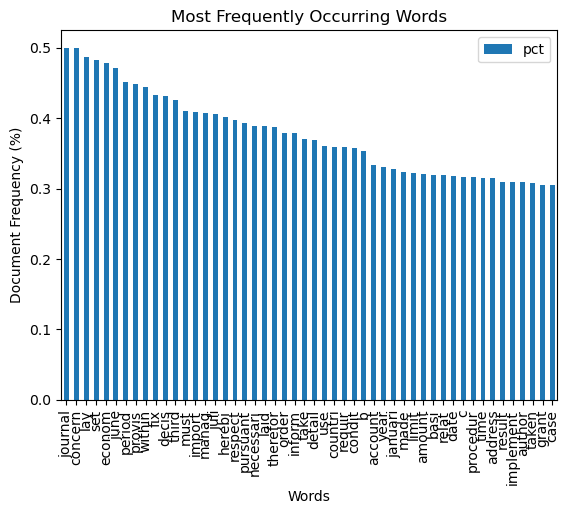

In [14]:

plt.figure(figsize=(10, 40))
train_wd_ct_df.head(50).plot(x='word', y='pct', kind='bar')
plt.xlabel('Words')
plt.ylabel('Document Frequency (%)')
plt.title('Most Frequently Occurring Words')
plt.show()


## Baseline (ie non ML solution) + metrics on test set


We'll do a logistic regression for the baseline model. 

### Logistic Regression Preprocessing

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

df_train.head()

,celex_id,text,labels,pp_text
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,"[2, 5, 10, 8, 3, 18, 15]",june th time impos specif restrict direct pers...
1,32008R0284,COMMISSION REGULATION (EC) No 284/2008\nof 27 ...,"[3, 18, 17, 6]",march regist name regist protect design origin...
2,32004D0761,COMMISSION DECISION\nof 26 October 2004\nlayin...,"[17, 19, 10, 6, 15]",decis octob lay detail direct statist survey c...
3,31992R2310,COMMISSION REGULATION (EEC) No 2310/92 of 31 J...,"[7, 3, 17, 6]",juli buyingin storag oliv oil intervent agenc ...
4,31995R0423,COUNCIL REGULATION (EC) No 423/95 of 20 Februa...,"[17, 19, 6]",februari lay respect hop amount aid produc har...


In [23]:
df_train['text'][:100].to_dict()

{0: 'Commission Regulation (EC) No 1012/2003\nof 12 June 2003\namending for the 19th time Council Regulation (EC) No 881/2002 imposing certain specific restrictive measures directed against certain persons and entities associated with Usama bin Laden, the Al-Qaida network and the Taliban, and repealing Council Regulation (EC) No 467/2001\nTHE COMMISSION OF THE EUROPEAN COMMUNITIES,\nHaving regard to the Treaty establishing the European Community,\nHaving regard to Council Regulation (EC) No 881/2002 of 27 May 2002 imposing certain specific restrictive measures directed against certain persons and entities associated with Usama bin Laden, the Al-Qaida network and the Taliban, and repealing Council Regulation (EC) No 467/2001 prohibiting the export of certain goods and services to Afghanistan, strengthening the flight ban and extending the freeze of funds and other financial resources in respect of the Taliban of Afghanistan(1), as last amended by Commission Regulation (EC) No 866/2003(2

Let's make a feature for the date it was published. 

In [36]:
def extract_date(text):
    pattern = r'(?<=of\s)(\d{1,2})\s([A-Za-z]+)\s(\d{4})'
    
    match = re.search(pattern, text.lower())
    if match:
        date_str = match.group()
        return pd.to_datetime(date_str, format='%d %B %Y')
    else:
        return np.nan
df_train['pub_date'] = df_train['text'].apply(extract_date)

0

In [11]:
train_exp.head()

,celex_id,text,labels
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,2
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,5
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,10
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,8
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,3


In [17]:
concepts_df = []
for i, v in eurovoc_concepts.items():
    result = {'concept_id': i, 'label': v['en']}
    concepts_df.append(result)
concepts_df = pd.DataFrame(concepts_df)
concepts_df.head()

,concept_id,label
0,100149,social questions
1,100160,industry
2,100148,finance
3,100147,trade
4,100152,business and competition


In [18]:
concepts_df['label']

NameError: name 'concepts_df' is not defined

In [17]:
from datasets import load_dataset
dataset = load_dataset('nlpaueb/multi_eurlex', 'all_languages')


AttributeError: 'MultiEURLEX' object has no attribute 'languages'

## RNN solution + metrics on test set


## BERT model + metrics on test set